# <strong><em> Project n°4: Analysis of "WeRateDogs" Twitter data</em></strong> <img src="files/doggo.jpg" width="200" height="100" style="float:right">

# Table of Contents
1. [Gather data](#gather)


2. [Assess data](#assess)
    
    2.1 [Visual assess](#visual)
    
    2.2 [Programatic assess](#prog)   
    
    
3. [Cleaning data](#clean)


4. [Data Insights](#ins)

## 1. Gather data
<a id='gather'> </a>

We first import all the libraries required for this analysis. 

In [9]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
%matplotlib inline

Then we import the data from the different sources

In [21]:
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")

In [22]:
tweets_list = []
tweets_json = open('tweet.txt',"r") 
for tweet in tweets_json:
    tweets_list.append(json.loads(tweet))
df_tweets = pd.DataFrame.from_dict(data = tweets_list)

In [23]:
im_predict = pd.read_csv("image-predictions.tsv", sep='\t')

## 2. Assess data
<a id='assess'> </a>

### a) We visualy aseess the data
<a id='visual'> </a>

In [24]:
# Display the twitter archive table:
#twitter_archive

In [25]:
# Display the json file table:
#df_tweets

In [26]:
# Display the twitter prediction table:
#im_predict

### b) We programatic assess the data
<a id='prog'> </a>

b.1) Twitter_archive: 

In [27]:
#twitter_archive.head()

In [28]:
#twitter_archive.describe()

In [29]:
#twitter_archive.info()

b.2) df_tweets

In [30]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2354 non-null object
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

In [31]:
#df_tweets.info()

In [32]:
#df_tweets.describe()

b.3) im_predict

In [33]:
#im_predict.head()

In [34]:
#im_predict.info()

In [35]:
#im_predict.describe()

#### Quality
1) Some rows are retweets so they do not count for the analysis

2) The are also some tweets that are replies so they won't be considered in the analysis

3) Missing data in the name of the dogs

4) In the Twitter_archive some Names have just one letter

5) The rating numerator has values over 1000

6) The rating denominator has values over 10

7) The RTs from the df_tweets data base must be remove for the analysis

8) The replies from the df_tweets data base must be remove for the analysis

9) Date column in the tweets_df has a different format than the date column in twitter archive



#### Tidiness
1) Dates columns should be splited in date and time columns

2) The twitter archive, predictions and the tweets df should be one table

3) The stage of the dogs should be one column instead of 4



## 3. Cleaning data
<a id='clean'> </a>

We first create copies of every data set to clean the data
##### Quality Issues:

In [36]:
twitter_archive_clean = twitter_archive.copy()

In [37]:
df_tweets_clean = df_tweets.copy()

In [38]:
im_predict_clean = im_predict.copy()

1) **Define**: 

The number of tweets that must be removed from the df because they are RTs is calculated:

**Code**

In [39]:
sum(twitter_archive_clean.retweeted_status_id.notnull())

181

In [40]:
twitter_archive_clean = twitter_archive_clean[-twitter_archive_clean.retweeted_status_id.notnull()]

**Test**

In [41]:
sum(twitter_archive_clean.retweeted_status_id.notnull())

0

2) **Define**:

The number of tweets that must be removed from the df because they are replies is calculated:

**Code**

In [42]:
sum(twitter_archive_clean.in_reply_to_status_id.notnull())

78

In [43]:
twitter_archive_clean = twitter_archive_clean[-twitter_archive_clean.in_reply_to_status_id.notnull()]

**Test**

In [44]:
sum(twitter_archive_clean.in_reply_to_status_id.notnull())

0

3) **Define**: 

We deal with the tweets with no dogs name

**Code**

In [45]:
len(twitter_archive_clean.name)

2097

In [46]:
len(twitter_archive_clean[twitter_archive_clean.name != "None"])

1494

Since there are too many missing data in this variable, we decided not to use it

4) **Define**: 

We look for tweets with wrong dog's names:

**Code**

In [47]:
#twitter_archive_clean.groupby(['name']).count()

Since it's not possible to fix the problems in the recolection of the names of the dogs, we won't use this column. The names were colected from the tweet if they started with "This is" but not all tweets said the name after those words so there are too many errors. 

5) **Define**: 

The rating numerator has some values over 1000

**Code**

In [48]:
np.percentile(twitter_archive_clean.rating_numerator, 99)

14.0

In [49]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.rating_numerator<15]

**Test**

In [50]:
np.percentile(twitter_archive_clean.rating_numerator, 99)

14.0

6) **Define**: 

The rating denominator has some values over 10

**Code**

In [51]:
np.percentile(twitter_archive_clean.rating_denominator, 99)

10.0

In [52]:
np.percentile(twitter_archive_clean.rating_denominator, 0)

2.0

In [53]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.rating_denominator<11]

In [54]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.rating_denominator>=10]

**Test**

In [55]:
np.percentile(twitter_archive_clean.rating_denominator, 0)

10.0

7) **Define**: 

The number of tweets that must be removed from the df because they are RT is calculated:

**Code**

In [56]:
sum(df_tweets_clean.retweeted_status.notnull())

179

In [57]:
df_tweets_clean = df_tweets_clean[-df_tweets_clean.retweeted_status.notnull()]

**Test**

In [58]:
sum(df_tweets_clean.retweeted_status.notnull())

0

8) **Define**: 

The number of tweets that must be removed from the df because they are replies is calculated:

**Code**

In [59]:
sum(df_tweets_clean.in_reply_to_status_id.notnull())

78

In [60]:
df_tweets_clean = df_tweets_clean[-df_tweets_clean.in_reply_to_status_id.notnull()]

**Test**

In [61]:
sum(df_tweets_clean.in_reply_to_status_id.notnull())

0

9) **Define**: 

We fix the format of the dates

**Code**

In [62]:
twitter_archive_clean['DateTime'] = pd.to_datetime(twitter_archive_clean['timestamp'])

In [63]:
#twitter_archive.head()

In [64]:
df_tweets_clean['DateTime'] = pd.to_datetime(df_tweets_clean['created_at'])

**Test**

In [65]:
#df_tweets_clean.head()

##### Tidiness Issues
a) **Define**: 

We take just the year from the date of the tweets for posterior analysis

**Code**

In [66]:
twitter_archive_clean['year'] = twitter_archive_clean['DateTime'].dt.year

In [67]:
twitter_archive_clean.year.describe()

count    2075.000000
mean     2015.860723
std         0.693248
min      2015.000000
25%      2015.000000
50%      2016.000000
75%      2016.000000
max      2017.000000
Name: year, dtype: float64

In [68]:
df_tweets_clean['year'] = df_tweets_clean['DateTime'].dt.year

**Test**

In [69]:
df_tweets_clean.year.describe()

count    2097.000000
mean     2015.860277
std         0.691435
min      2015.000000
25%      2015.000000
50%      2016.000000
75%      2016.000000
max      2017.000000
Name: year, dtype: float64

b) **Define**: 

We tidy the doggo stage columns since there are 4 and could be one. 

**Code**

In [70]:
twitter_archive_clean.doggo.replace('None', '', inplace = True)

In [71]:
twitter_archive_clean.floofer.replace('None', '', inplace = True)

In [72]:
twitter_archive_clean.pupper.replace('None', '', inplace = True)

In [73]:
twitter_archive_clean.puppo.replace('None', '', inplace = True)

In [74]:
twitter_archive_clean['Dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

In [75]:
#twitter_archive_clean['Dog_stage'].head()

In [76]:
twitter_archive_clean.loc[twitter_archive_clean.Dog_stage == 'doggopupper', 'Dog_stage'] = 'doggo,pupper'

In [77]:
twitter_archive_clean.loc[twitter_archive_clean.Dog_stage == 'doggopuppo', 'Dog_stage'] = 'doggo,puppo'

In [78]:
twitter_archive_clean.loc[twitter_archive_clean.Dog_stage == 'doggofloofer', 'Dog_stage'] = 'doggo,floofer'

**Test**

In [79]:
#twitter_archive_clean['Dog_stage'].head()

c) **Define**: 

We merge the tables that should be together

**Code**

In [80]:
all_columns = pd.Series(list(twitter_archive_clean) + list(im_predict))
all_columns[all_columns.duplicated()]

20    tweet_id
dtype: object

In [81]:
twitter_archive_predic = pd.merge(twitter_archive_clean, im_predict_clean, on='tweet_id', how='inner')

In [82]:
#twitter_archive_predic.info()

In [83]:
df_tweets_clean['tweet_id'] = df_tweets_clean['id']
all_columns = pd.Series(list(twitter_archive_predic) + list(df_tweets_clean))
all_columns[all_columns.duplicated()]

44    in_reply_to_status_id
46      in_reply_to_user_id
59                   source
62                 DateTime
63                     year
64                 tweet_id
dtype: object

In [111]:
twitter_archive_df= pd.merge(twitter_archive_predic, df_tweets_clean, on='tweet_id', how='inner')

**Test**

In [112]:
#twitter_archive_df.head()

In [113]:
twitter_archive_df.shape

(1949, 64)

We finally save the data in a CSV file

In [114]:
twitter_archive_df.to_csv("twitter_archive_df.csv", index=False)

## 4. Data Insights
<a id='ins'> </a>

In [115]:
twitter_data = pd.read_csv("twitter_archive_df.csv")

In [116]:
twitter_data['rating'] = twitter_data.rating_numerator/twitter_data.rating_denominator

In [117]:
twitter_data.describe()

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,year_x,img_num,...,in_reply_to_status_id_str,in_reply_to_user_id_y,in_reply_to_user_id_str,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted_status,year_y,rating
count,1.949000e+03,0.0,0.0,0.0,0.0,0.0,1949.000000,1949.0,1949.000000,1949.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1949.000000,0.0,1949.000000,1949.000000
mean,7.361975e+17,NaN,NaN,NaN,NaN,NaN,10.538225,10.0,2015.847614,1.202668,...,NaN,NaN,NaN,NaN,NaN,NaN,2784.492560,NaN,2015.847614,1.053822
std,6.772838e+16,NaN,NaN,NaN,NaN,NaN,2.174663,0.0,0.701180,0.560024,...,NaN,NaN,NaN,NaN,NaN,NaN,4709.940601,NaN,0.701180,0.217466
min,6.660209e+17,NaN,NaN,NaN,NaN,NaN,0.000000,10.0,2015.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,2015.000000,0.000000
25%,6.758209e+17,NaN,NaN,NaN,NaN,NaN,10.000000,10.0,2015.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,624.000000,NaN,2015.000000,1.000000
50%,7.087381e+17,NaN,NaN,NaN,NaN,NaN,11.000000,10.0,2016.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1360.000000,NaN,2016.000000,1.100000
75%,7.887659e+17,NaN,NaN,NaN,NaN,NaN,12.000000,10.0,2016.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,3240.000000,NaN,2016.000000,1.200000
max,8.924206e+17,NaN,NaN,NaN,NaN,NaN,14.000000,10.0,2017.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,79515.000000,NaN,2017.000000,1.400000


In [118]:
twitter_grouped_breed = twitter_data.groupby(['p1', 'year_x']).mean()

#### a) Breeds with the highest rating

In [119]:
twitter_grouped_breed[twitter_grouped_breed.rating == max(twitter_grouped_breed.rating)]

,,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,img_num,p1_conf,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,truncated,year_y,rating
p1,year_x,,,,,,,,,,,,,,,,,,,,,
Gordon_setter,2017,8.203146e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,2.0,0.940724,...,0.0,NaN,NaN,NaN,648.0,0.0,NaN,0.0,2017.0,1.4
Irish_setter,2017,8.214072e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,1.0,0.505496,...,0.0,NaN,NaN,NaN,5053.0,0.0,NaN,0.0,2017.0,1.4
black-and-tan_coonhound,2017,8.541204e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,4.0,0.854861,...,0.0,NaN,NaN,NaN,8285.0,0.0,NaN,0.0,2017.0,1.4
chimpanzee,2017,8.601848e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,1.0,0.267612,...,0.0,NaN,NaN,NaN,6295.0,0.0,NaN,0.0,2017.0,1.4
comic_book,2017,8.700632e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,1.0,0.534409,...,0.0,NaN,NaN,NaN,8840.0,0.0,NaN,0.0,2017.0,1.4
laptop,2017,8.688804e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,1.0,0.153718,...,0.0,NaN,NaN,NaN,12518.0,0.0,NaN,0.0,2017.0,1.4
limousine,2017,8.875171e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,1.0,0.130432,...,0.0,NaN,NaN,NaN,12082.0,0.0,NaN,0.0,2017.0,1.4
military_uniform,2017,8.414399e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,3.0,0.853684,...,0.0,NaN,NaN,NaN,4168.0,0.0,NaN,0.0,2017.0,1.4
pedestal,2016,7.942053e+17,NaN,NaN,NaN,NaN,NaN,14.0,10.0,3.0,0.662660,...,0.0,NaN,NaN,NaN,3895.0,0.0,NaN,0.0,2016.0,1.4


#### b) Least favorite breeds

In [120]:
twitter_grouped_breed[twitter_grouped_breed.rating == min(twitter_grouped_breed.rating)]

,,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,img_num,p1_conf,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,truncated,year_y,rating
p1,year_x,,,,,,,,,,,,,,,,,,,,,
electric_fan,2015,6.675491e+17,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,0.984377,...,0.0,NaN,NaN,NaN,2454.0,0.0,NaN,0.0,2015.0,0.1
lacewing,2015,6.707834e+17,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,0.381955,...,0.0,NaN,NaN,NaN,431.0,0.0,NaN,0.0,2015.0,0.1
paper_towel,2015,6.751534e+17,NaN,NaN,NaN,NaN,NaN,1.0,10.0,1.0,0.327957,...,0.0,NaN,NaN,NaN,2734.0,0.0,NaN,0.0,2015.0,0.1


#### c) What changes if we filter by prediction confidence?

In [121]:
twitter_grouped_breed_clean = twitter_data[twitter_data.p1_dog == True]
twitter_grouped_breed_clean = twitter_grouped_breed_clean.groupby(['p1', 'year_x']).mean()

In [98]:
twitter_grouped_breed_clean[twitter_grouped_breed_clean.rating == max(twitter_grouped_breed_clean.rating)]

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source_y,truncated,user,DateTime_y,year_y,rating
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-26 15:59:51,2017,1.4
36,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,...,NaN,5856,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-10 15:58:53,2017,1.4
49,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,...,NaN,16570,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-02 15:32:16,2017,1.4
64,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878057613...,...,NaN,7181,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-06-23 01:10:23,2017,1.4
145,856282028240666624,NaN,NaN,2017-04-23 23:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Cermet, Paesh, and Morple. They are ab...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856282028...,...,NaN,6841,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-04-23 23:01:59,2017,1.4
151,854120357044912130,NaN,NaN,2017-04-17 23:52:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Sometimes you guys remind me just how impactfu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/854120357...,...,NaN,8285,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-04-17 23:52:16,2017,1.4
250,832273440279240704,NaN,NaN,2017-02-16 17:00:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Smiley. He's a blind therapy dogg...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832273440...,...,NaN,2673,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-02-16 17:00:25,2017,1.4
253,831911600680497154,NaN,NaN,2017-02-15 17:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Kuyu. He was trapped in a well for 10 day...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831911600...,...,NaN,7458,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-02-15 17:02:36,2017,1.4
272,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,...,NaN,1544,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-02-06 17:02:17,2017,1.4
275,828381636999917570,NaN,NaN,2017-02-05 23:15:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Doobert. He's a deaf doggo. Didn't stop h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/828381636...,...,NaN,255

In [122]:
twitter_grouped_breed_clean[twitter_grouped_breed_clean.rating == min(twitter_grouped_breed_clean.rating)]

,,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,rating_numerator,rating_denominator,img_num,p1_conf,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,truncated,year_y,rating
p1,year_x,,,,,,,,,,,,,,,,,,,,,
Boston_bull,2015,6.765883e+17,NaN,NaN,NaN,NaN,NaN,5.0,10.0,1.0,0.976577,...,0.0,NaN,NaN,NaN,896.0,0.0,NaN,0.0,2015.0,0.5
Japanese_spaniel,2015,6.773010e+17,NaN,NaN,NaN,NaN,NaN,5.0,10.0,1.0,0.661178,...,0.0,NaN,NaN,NaN,471.0,0.0,NaN,0.0,2015.0,0.5


#### Most popular breeds

In [125]:
# twitter_data.info()

Text(0,0.5,'Number of RTs')

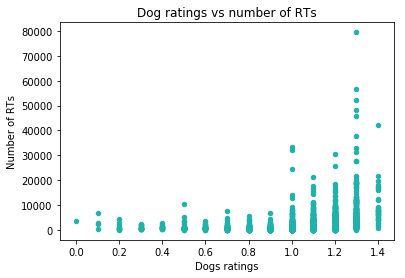

In [126]:
twitter_data.plot.scatter(x='rating', y='retweet_count', c='lightseagreen', title = 'Dog ratings vs number of RTs')
plt.xlabel('Dogs ratings')
plt.ylabel('Number of RTs')

We can see a positive relationship betweet the rating of the dogs and the number of RTs that they get

<img src="files/pcdoggo.jpg" width="200" height="100">